In [1]:
%matplotlib inline
import sys
sys.path.append('..')
import time
import math
import warnings 
import numpy as np
import matplotlib.pyplot as plt
from functions.indicators import indicator
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from functions.models import mode_0, mode_1, mode_2, mode_3, mode_4, mode_5, mode_6
from functions.comparison import gaussian_closedform, gaussian_gradientdescent, poly_ERM,kernelregression_closedform
from functions.clossfunction import Closs
from functions.createdata import CreateData
warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size':15})

# Data generation

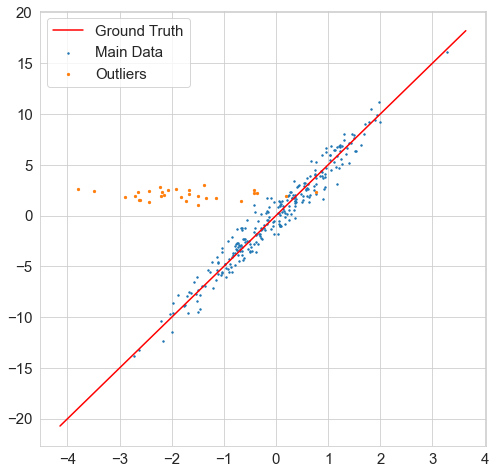

In [2]:
X, y, Xtst, ytst = CreateData(1,'gaussian') # dimension = 1

# ERM

training set
 max loss: 161.73646431078856, min loss: 4.640765727772905e-05, avg loss: 9.978739163452138, variance: 378.4425302581342
test set
max loss: 52.50887387922764, min loss: 7.846860907786185e-06, avg loss: 5.59825744040521, variance: 63.34431428141065


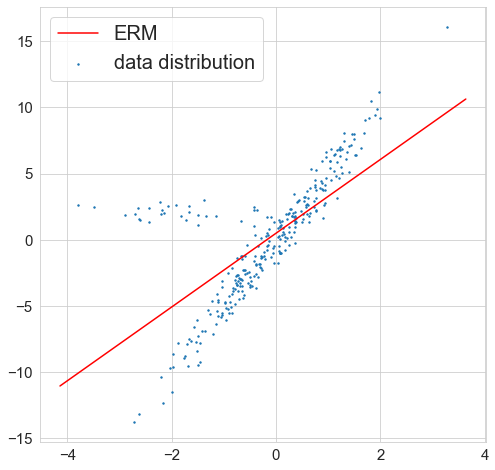

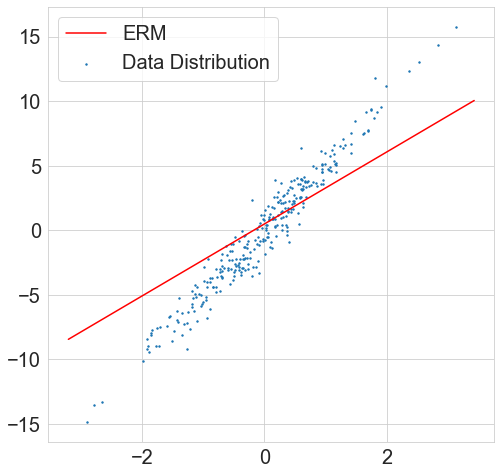

In [3]:
mode_0(X, y, Xtst, ytst,iters=500,learning_step=0.002,tol = 1/10**8,losstype='mse',h=1,delta=2,online = False )

# EDERM  Gaussian KDE kernel

In [4]:
def abline(a,  label_, c=None ):
    axes       = plt.gca()
    x_vals     = np.array(axes.get_xlim())
    x_vals     = x_vals.reshape((x_vals.shape[0], 1))
    intercept  = np.ones((x_vals.shape[0], 1))
    x_vals     = np.concatenate((x_vals, intercept), axis=1) 
    y_vals     = np.dot(x_vals , a)
    plt.plot(x_vals[:,0:-1], y_vals, label=label_, color=c)

In [5]:
def kerneldensity(loss,fai): 
    '''
        loss:   y-y_pred  
    '''
    lossinds    = loss.argsort()
    sorted_loss = loss[lossinds[:]]
    x2          = sorted_loss
    y2          = fai[lossinds[:]]   # final ρ
    plt.figure(figsize=(8, 8))
    plt.plot(x2,y2,label='Final density',linewidth=2,color='r',marker='o', markerfacecolor='blue',markersize=4)
    plt.hist(loss, bins = 20,density = True)
    plt.grid(True) 
    plt.xlabel('Error Value') 
    plt.ylabel('Density') 
    # plt.title('The final error density',fontsize= 'xx-large') 
    plt.legend() 
    plt.show()

In [6]:
def gau_EDERM(X, y, Xtst, ytst,iters,lamb,learning_step,tol,Ictype,losstype,h,delta,online,flag='LS'):
    '''
        correntropy-Induced approximated Indicator single mode
        linear regression y = x*w + b
        λ<ρ restrict the indicator function I  = I(ρ>λ)
        We have the following
            F = sum(f(zi) * I)/n = sum(f(zi) * I(ρ>λ))/n 
           dF = sum(df*I + f*dI )/n 
    '''
    #init params
    intercept  = np.ones((X.shape[0], 1))
    X_         = np.concatenate((X, intercept), axis=1)
    intercept  = np.ones((Xtst.shape[0], 1))
    Xtst_      = np.concatenate((Xtst, intercept), axis=1)
    n          = X_.shape[0]
    features   = X_.shape[1]
    theta_hat  = np.zeros(features)
    for k in range(iters):
        Ic     =  np.zeros(n)
        R      =  np.zeros(iters)   
        mainx  =  []  #save important points
        mainy  =  []
        grad   =  np.zeros(features)
        fai    =  np.zeros(n) #final error density
        dfai   =  np.zeros([n,features])
        loss   =  np.zeros(n)
        dloss  =  np.zeros([n,features])
        Ic     =  np.zeros(n)
        Points =  np.zeros(n)
        dIc    =  np.zeros([n,features])
        y_pred =  np.dot(X_, theta_hat)
        error  =  (y-y_pred) 
        errors =  (y-y_pred)* (y-y_pred) 
        olderr = mse(y,y_pred)
        for i in range(0,n):
            for j in range(0,n):
                # KDE kernel ： Gaussian kernel
                fai[i]  = fai[i]  + (1/(n*h))* math.exp((error[i]-error[j])**2/(-2*h*h))
                dfai[i] = dfai[i] + (1/(n*h))* math.exp((error[i]-error[j])**2/(-2*h*h)) \
                    * ((error[i]-error[j])/(h*h)) *(X_[i].T)
            if(losstype == 'mse'):
                loss[i] = error[i]**2
                dloss[i]= (2*X_[i].T*(y_pred[i]-y[i]))
            elif(losstype == 'closs'):
                loss[i] = delta * delta * (1 - math.exp(error[i]**2 / (-2*delta*delta))) 
                dloss[i]= ( math.exp(error[i]**2 / (-2*delta*delta)))  * X_[i].T*(y_pred[i]-y[i])
            Ic[i],dIc[i]     = indicator(Ictype, fai[i], dfai[i], lamb,delta)
            R[k]    +=  errors[i]*Ic[i]
            grad    +=  dloss[i]*Ic[i]+loss[i]*dIc[i]
            if(fai[i]>lamb):
                Points[i]=1
                mainx.append(X[i])
                mainy.append(y[i])
            else:
                Points[i]=0   
        theta_hat = theta_hat - learning_step * grad 
        newerr = mse(y,np.dot(X_, theta_hat))
        if(online == True):
            print("iterations",k,"Errors",newerr)
        if(abs(newerr - olderr) < tol):
            break

    #show density info
    kerneldensity(error,fai)
    
    print("training set")
    y_pred = np.dot(X_, theta_hat)
    loss = (y-y_pred)* (y-y_pred)
    print("ρ>{}, max loss: {}, min loss: {}, avg loss: {}, variance: {}".format(lamb, max(loss), min(loss), np.mean(loss), np.var(loss)))

    if(features==2):
        plt.figure(figsize=(8, 8))
        plt.scatter(X, y, s=2, label='Data Distribution')
        if(flag=='LS'):
            plt.scatter(mainx, mainy, s=2)
            abline(theta_hat,  'EDERM (gaussian kernel)')
        else:
            abline(theta_hat,  'Correntropy', "red")
        plt.grid(True)
        plt.legend()

    print("test set")    
    ytst_pred = np.dot(Xtst_,theta_hat)
    loss = (ytst-ytst_pred)* (ytst-ytst_pred)
    print("ρ>{}, max loss: {}, min loss: {}, avg loss: {}, variance: {}".format(lamb, max(loss), min(loss), np.mean(loss), np.var(loss)))
    if(features==2):
        plt.figure(figsize=(8, 8))
        plt.scatter(Xtst, ytst, s=2, label='Data distribution')
        if(flag=='LS'):
            abline(theta_hat,  'EDERM (gaussian kernel)')
        else:
            abline(theta_hat,  'Correntropy', "red")
        plt.grid(True) 
        plt.legend()
    print("The linear weight: ",theta_hat[-2],"the constrant:",theta_hat[-1])

iterations 0 Errors 21.139084863675667
iterations 1 Errors 20.815151748188235
iterations 2 Errors 20.501575930698337
iterations 3 Errors 20.196092279466384
iterations 4 Errors 19.8965149723759
iterations 5 Errors 19.60077396622738
iterations 6 Errors 19.306925121914503
iterations 7 Errors 19.013143991727095
iterations 8 Errors 18.717714303664508
iterations 9 Errors 18.41902363107207
iterations 10 Errors 18.11558050876993
iterations 11 Errors 17.806068302344663
iterations 12 Errors 17.489448830000903
iterations 13 Errors 17.165116725455885
iterations 14 Errors 16.833072356010778
iterations 15 Errors 16.494022398708232
iterations 16 Errors 16.149277682974038
iterations 17 Errors 15.800417106172617
iterations 18 Errors 15.44897198599959
iterations 19 Errors 15.09656278281506
iterations 20 Errors 14.745553221315204
iterations 21 Errors 14.399559005825221
iterations 22 Errors 14.06296099479339
iterations 23 Errors 13.739467041345051
iterations 24 Errors 13.430847091707236
iterations 25 Erro

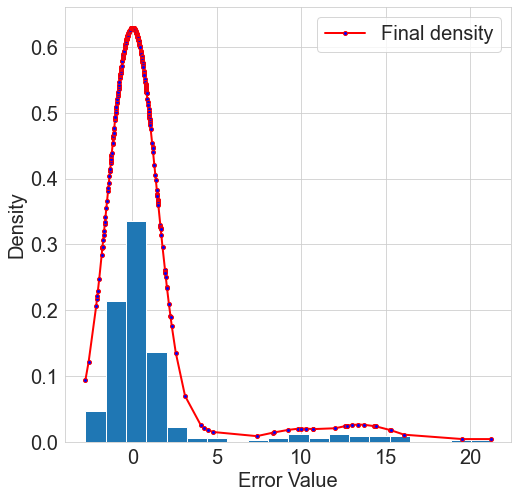

training set
ρ>1, max loss: 450.54661682916566, min loss: 0.00017944013464840682, avg loss: 15.021525276147022, variance: 2851.876331110766
test set
ρ>1, max loss: 11.69541877629314, min loss: 8.660080234018187e-05, avg loss: 1.0755738445905758, variance: 2.9513406864591847
The linear weight:  4.906219346146436 the constrant: 0.017339642863147486


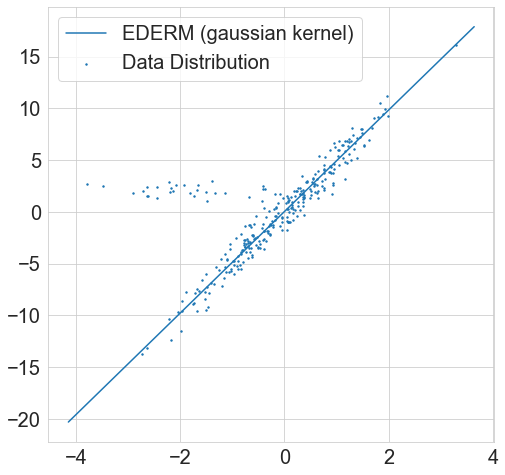

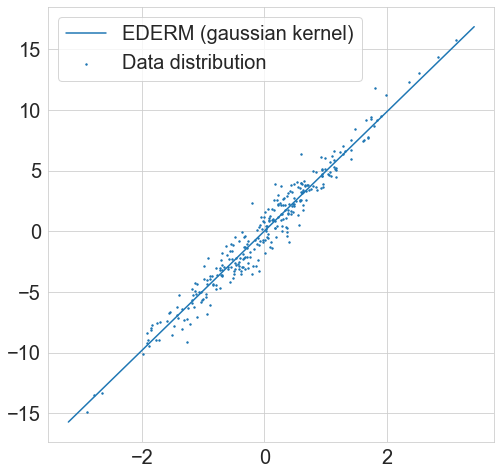

In [7]:
gau_EDERM(X, y, Xtst, ytst,iters=200,lamb=1,learning_step=0.002,tol = 1/10**8,Ictype='correntropy',losstype='mse',h=1,delta=2,online =True)

# EDRM  Epanechnikov KDE kernel 

In [8]:
def epa_EDERM(X, y, Xtst, ytst,iters,lamb,learning_step,tol,Ictype,h,delta,online,flag='LS'):
    '''
        correntropy-Induced approximated Indicator single mode
        linear regression y = x*w + b
        λ<ρ restrict the indicator function I  = I(ρ>λ)
        We have the following
            F = sum(f(zi) * I)/n = sum(f(zi) * I(ρ>λ))/n 
           dF = sum(df*I + f*dI )/n 
    '''
    #init params
    intercept  = np.ones((X.shape[0], 1))
    X_         = np.concatenate((X, intercept), axis=1)
    intercept  = np.ones((Xtst.shape[0], 1))
    Xtst_      = np.concatenate((Xtst, intercept), axis=1)
    n          = X_.shape[0]
    features   = X_.shape[1]
    theta_hat  = np.zeros(features)
    for k in range(iters):
        Ic     =  np.zeros(n)
        R      =  np.zeros(iters)
        mainx  =  []  #save important points
        mainy  =  []
        grad   =  np.zeros(features)
        fai    =  np.zeros(n) #final error density

        dfai   =  np.zeros([n,features])
        loss   =  np.zeros(n)
        dloss  =  np.zeros([n,features])
        Ic     =  np.zeros(n)
        Points =  np.zeros(n)
        dIc    =  np.zeros([n,features])
        y_pred =  np.dot(X_, theta_hat)
        error  =  (y-y_pred) 
        errors =  (y-y_pred)* (y-y_pred) 
        olderr = mse(y,y_pred)
        for i in range(0,n):
            for j in range(0,n):
                if((error[i]-error[j])**2 <=1):  
                    # KDE kernel ： Epanechnikov kernel
                    fai[i]  = fai[i]  + (1/(n*h))* (3/4) * (1-(error[i]-error[j])**2)
                    dfai[i] = dfai[i] + (1/(n*h))* (3/4) * 2 * (error[i]-error[j])*(X_[i].T)
            loss[i] = error[i]**2
            dloss[i]= (2*X_[i].T*(y_pred[i]-y[i]))
            Ic[i],dIc[i]     = indicator(Ictype, fai[i], dfai[i], lamb,delta)
            R[k]    +=  errors[i]*Ic[i]
            grad    +=  dloss[i]*Ic[i]+loss[i]*dIc[i]
            if(fai[i]>lamb):
                Points[i]=1
                mainx.append(X[i])
                mainy.append(y[i])
            else:
                Points[i]=0   
        theta_hat = theta_hat - learning_step * grad 
        newerr = mse(y,np.dot(X_, theta_hat))
        if(online == True):
            print("iterations",k,"Errors",newerr)
        if(abs(newerr - olderr) < tol):
            break
    #show density info
    kerneldensity(errors,fai)
    
    print("training set")
    y_pred = np.dot(X_, theta_hat)
    loss = (y-y_pred)* (y-y_pred)
    print("ρ>{}, max loss: {}, min loss: {}, avg loss: {}, variance: {}".format(lamb, max(loss), min(loss), np.mean(loss), np.var(loss)))

    if(features==2):
        plt.figure(figsize=(8, 8))
        plt.scatter(X, y, s=2, label='Data Distribution')
        if(flag=='LS'):
            plt.scatter(mainx, mainy, s=2)
            abline(theta_hat,  'EDERM (epanechnikov kernel)')
        else:
            abline(theta_hat,  'Correntropy', "red")
        plt.grid(True)
        plt.legend()

    print("test set")    
    ytst_pred = np.dot(Xtst_,theta_hat)
    loss = (ytst-ytst_pred)* (ytst-ytst_pred)
    print("ρ>{}, max loss: {}, min loss: {}, avg loss: {}, variance: {}".format(lamb, max(loss), min(loss), np.mean(loss), np.var(loss)))
    if(features==2):
        plt.figure(figsize=(8, 8))
        plt.scatter(Xtst, ytst, s=2, label='Data distribution')
        if(flag=='LS'):
            abline(theta_hat,  'EDERM (epanechnikov kernel)')
        else:
            abline(theta_hat,  'Correntropy', "red")
        plt.grid(True) 
        plt.legend()
    print("The linear weight: ",theta_hat[-2],"the constrant:",theta_hat[-1])

iterations 0 Errors 21.221294910994494
iterations 1 Errors 20.973143278481206
iterations 2 Errors 20.729666967984347
iterations 3 Errors 20.48612679886234
iterations 4 Errors 20.24887586851004
iterations 5 Errors 20.017794691295293
iterations 6 Errors 19.789475516266442
iterations 7 Errors 19.561589380355187
iterations 8 Errors 19.332535779652808
iterations 9 Errors 19.110021932098128
iterations 10 Errors 18.893855650904257
iterations 11 Errors 18.672721052069484
iterations 12 Errors 18.453074839449723
iterations 13 Errors 18.238142118930387
iterations 14 Errors 18.02031886402049
iterations 15 Errors 17.804263347146716
iterations 16 Errors 17.58525027876499
iterations 17 Errors 17.369538074447572
iterations 18 Errors 17.152347405824745
iterations 19 Errors 16.92817462861941
iterations 20 Errors 16.704308119204125
iterations 21 Errors 16.498249181400073
iterations 22 Errors 16.292162769777125
iterations 23 Errors 16.088628880598733
iterations 24 Errors 15.882079262703051
iterations 25 E

iterations 204 Errors 14.291573805408964
iterations 205 Errors 14.292156242204765
iterations 206 Errors 14.29265058274896
iterations 207 Errors 14.293082862270763
iterations 208 Errors 14.293481587886378
iterations 209 Errors 14.293835609672275
iterations 210 Errors 14.29416957276039
iterations 211 Errors 14.294447864601583
iterations 212 Errors 14.294737913294547
iterations 213 Errors 14.295028973353777
iterations 214 Errors 14.29529376683047
iterations 215 Errors 14.29557287533778
iterations 216 Errors 14.295805364799492
iterations 217 Errors 14.29599900899599
iterations 218 Errors 14.296208952959736
iterations 219 Errors 14.29643987341194
iterations 220 Errors 14.296644146609895
iterations 221 Errors 14.296949219807875
iterations 222 Errors 14.297203493173669
iterations 223 Errors 14.297415414377015
iterations 224 Errors 14.297615607506701
iterations 225 Errors 14.297830063477974
iterations 226 Errors 14.298008860697946
iterations 227 Errors 14.298157921883314
iterations 228 Errors 

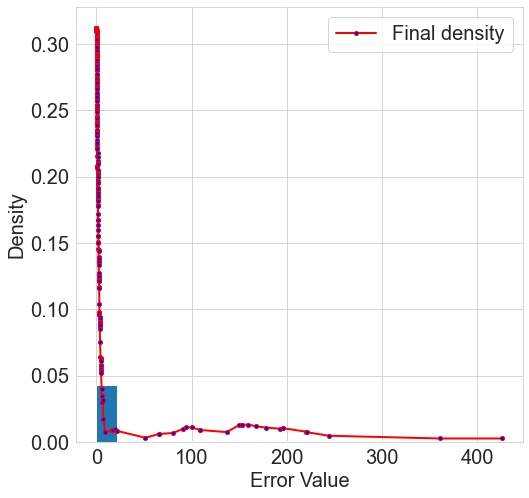

training set
ρ>0.95, max loss: 426.6595478801731, min loss: 6.403246344611111e-06, avg loss: 14.29956243072694, variance: 2557.5294492327944
test set
ρ>0.95, max loss: 12.1482061877588, min loss: 2.8068097871073396e-07, avg loss: 1.107625402216135, variance: 3.1400805194248997
The linear weight:  4.761267231977058 the constrant: 0.038325085592788216


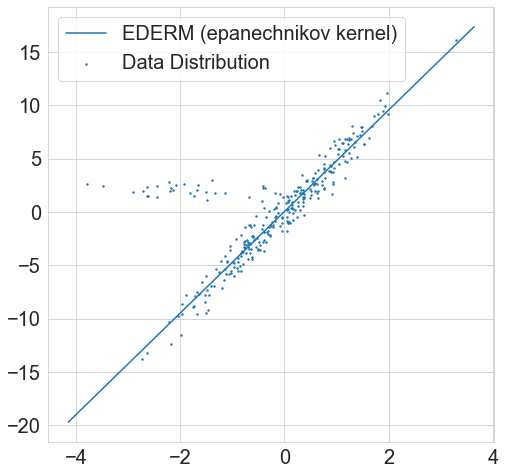

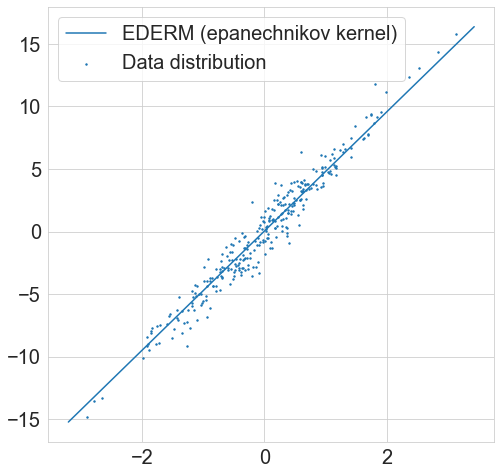

In [9]:
epa_EDERM(X, y, Xtst, ytst,iters=300,lamb=0.95,learning_step=0.002,tol = 1/10**12,Ictype='correntropy',h=1,delta=2,online =True)

# EDRM  Exponential KDE kernel 

In [10]:
def exp_EDERM(X, y, Xtst, ytst,iters,lamb,learning_step,tol,Ictype,h,delta,online,flag='LS'):
    '''
        correntropy-Induced approximated Indicator single mode
        linear regression y = x*w + b
        λ<ρ restrict the indicator function I  = I(ρ>λ)
        We have the following
            F = sum(f(zi) * I)/n = sum(f(zi) * I(ρ>λ))/n 
           dF = sum(df*I + f*dI )/n 
    '''
    #init params
    intercept  = np.ones((X.shape[0], 1))
    X_         = np.concatenate((X, intercept), axis=1)
    intercept  = np.ones((Xtst.shape[0], 1))
    Xtst_      = np.concatenate((Xtst, intercept), axis=1)
    n          = X_.shape[0]
    features   = X_.shape[1]
    theta_hat  = np.zeros(features)
    for k in range(iters):
        Ic     =  np.zeros(n)
        R      =  np.zeros(iters)
        mainx  =  []  #save important points
        mainy  =  []
        grad   =  np.zeros(features)
        fai    =  np.zeros(n) #final error density

        dfai   =  np.zeros([n,features])
        loss   =  np.zeros(n)
        dloss  =  np.zeros([n,features])
        Ic     =  np.zeros(n)
        Points =  np.zeros(n)
        dIc    =  np.zeros([n,features])
        y_pred =  np.dot(X_, theta_hat)
        error  =  (y-y_pred) 
        errors =  (y-y_pred)* (y-y_pred) 
        olderr = mse(y,y_pred)
        for i in range(0,n):
            for j in range(0,n):
                # KDE kernel ： Exponential kernel
                fai[i]  = fai[i]  + (1/(n*h))* math.exp((error[i]-error[j])/(-2*h))
                dfai[i] = dfai[i] + (1/(n*h))* math.exp((error[i]-error[j])/(-2*h)) * (X_[i].T) / (2*h)
            loss[i] = error[i]**2
            dloss[i]= (2*X_[i].T*(y_pred[i]-y[i]))
            Ic[i],dIc[i]     = indicator(Ictype, fai[i], dfai[i], lamb,delta)
            R[k]    +=  errors[i]*Ic[i]
            grad    +=  dloss[i]*Ic[i]+loss[i]*dIc[i]
            if(fai[i]>lamb):
                Points[i]=1
                mainx.append(X[i])
                mainy.append(y[i])
            else:
                Points[i]=0   
        theta_hat = theta_hat - learning_step * grad 
        newerr = mse(y,np.dot(X_, theta_hat))
        if(online == True):
            print("iterations",k,"Errors",newerr)
        if(abs(newerr - olderr) < tol):
            break
    #show density info
    kerneldensity(errors,fai)
    
    print("training set")
    y_pred = np.dot(X_, theta_hat)
    loss = (y-y_pred)* (y-y_pred)
    print("ρ>{}, max loss: {}, min loss: {}, avg loss: {}, variance: {}".format(lamb, max(loss), min(loss), np.mean(loss), np.var(loss)))

    if(features==2):
        plt.figure(figsize=(8, 8))
        plt.scatter(X, y, s=2, label='Data Distribution')
        if(flag=='LS'):
            plt.scatter(mainx, mainy, s=2)
            abline(theta_hat,  'EDERM (exponential kernel)')
        else:
            abline(theta_hat,  'Correntropy', "red")
        plt.grid(True)
        plt.legend()

    print("test set")    
    ytst_pred = np.dot(Xtst_,theta_hat)
    loss = (ytst-ytst_pred)* (ytst-ytst_pred)
    print("ρ>{}, max loss: {}, min loss: {}, avg loss: {}, variance: {}".format(lamb, max(loss), min(loss), np.mean(loss), np.var(loss)))
    
    if(features==2):
        plt.figure(figsize=(8, 8))
        plt.scatter(Xtst, ytst, s=2, label='Data distribution')
        if(flag=='LS'):
            abline(theta_hat,  'EDERM (exponential kernel)')
        else:
            abline(theta_hat,  'Correntropy', "red")
        plt.grid(True) 
        plt.legend()
    print("The linear weight: ",theta_hat[-2],"the constrant:",theta_hat[-1])

iterations 0 Errors 15.253029801491905
iterations 1 Errors 14.743923319615739
iterations 2 Errors 14.21657967442354
iterations 3 Errors 13.713310035914823
iterations 4 Errors 13.303306900620925
iterations 5 Errors 13.049821919039838
iterations 6 Errors 12.96594456095387
iterations 7 Errors 13.009737218785103
iterations 8 Errors 13.121903561449837
iterations 9 Errors 13.259769224101202
iterations 10 Errors 13.403743778741907
iterations 11 Errors 13.549988727146575
iterations 12 Errors 13.70042408300225
iterations 13 Errors 13.856439053284356
iterations 14 Errors 14.016756826795888
iterations 15 Errors 14.177659722971681
iterations 16 Errors 14.334189607536473
iterations 17 Errors 14.481456152232774
iterations 18 Errors 14.615592460177874
iterations 19 Errors 14.734211320853728
iterations 20 Errors 14.83641882313199
iterations 21 Errors 14.922513436255729
iterations 22 Errors 14.993698357364364
iterations 23 Errors 15.051675269671598
iterations 24 Errors 15.098322004392346
iterations 25 

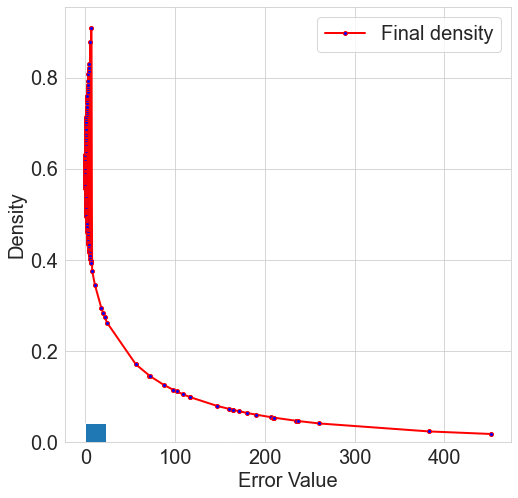

training set
ρ>1.1, max loss: 452.02126049333793, min loss: 4.458353017567799e-05, avg loss: 15.267802470637877, variance: 2909.0646698922783
test set
ρ>1.1, max loss: 13.174598111936662, min loss: 4.857187430604472e-05, avg loss: 1.1249852912302276, variance: 3.1769407676100676
The linear weight:  4.866302501828008 the constrant: -0.16865082288148547


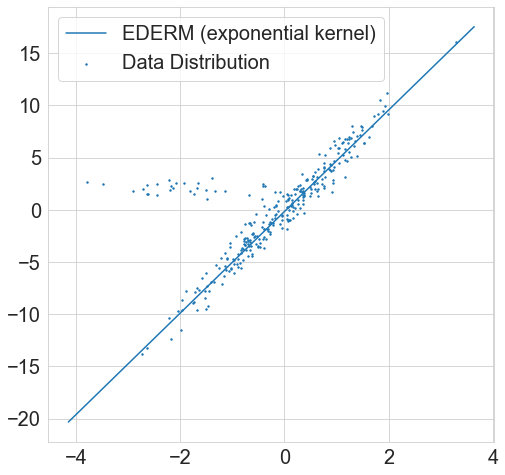

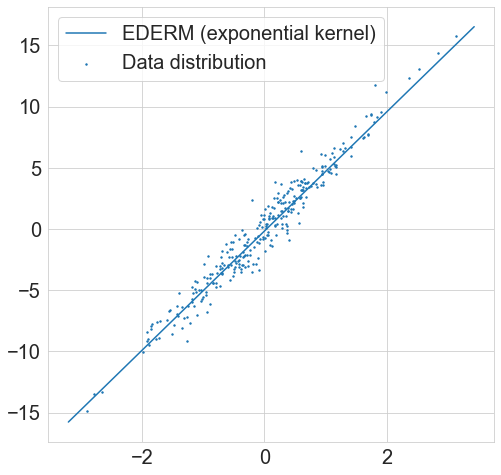

In [11]:
exp_EDERM(X, y, Xtst, ytst,iters=300,lamb=1.1,learning_step=0.002,tol = 1/10**12,Ictype='correntropy',h=3,delta=2,online =True)